Y-DATA 2020/21<br/>
Deep Learning HW5<br/>
Serge Tochilov

# Word Embeddings - Home Assigment
## Dr. Omri Allouche (c) 2021. YDATA Deep Learning Course

In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics (http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet). The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2Vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

> We employed `pandas` for data manipulation in this question. First download lyric's dataset.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from pathlib import Path
import os.path
import requests
from zipfile import ZipFile

def load_file(data_dir, url, fname, unzip=False):

    Path(data_dir).mkdir(parents=True, exist_ok=True)

    fpath = data_dir + os.sep + fname
    if Path(fpath).is_file():
        print('skipping', fpath)
        return fpath

    print('downloading', fpath)
    rsp = requests.get(url)
    rsp.raise_for_status()
    
    with open(fpath, 'wb') as f:
        f.write(rsp.content)

    if unzip:
        with ZipFile(fpath, 'r') as zip_obj:
            zip_obj.extractall(path=data_dir)
        
    return fpath

In [ ]:
# https://github.com/omriallouche/ydata_deep_learning_2021/raw/a50abc90b6bc63a302870f42d5ebd2ab0bb43499/data/metrolyrics.parquet
url = 'https://www.googleapis.com/drive/v3/files/1-T5W6sgkOVLNj59ep7rRqxJqTrpPIJxv?alt=media&key=<>'
fpath = load_file('.', url, 'metrolyrics.parquet')

df_songs = pd.read_parquet(fpath)

skipping ./metrolyrics.parquet


In [ ]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49976 entries, 204182 to 11180
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       49976 non-null  object
 1   year       49976 non-null  int64 
 2   artist     49976 non-null  object
 3   genre      49976 non-null  object
 4   lyrics     49976 non-null  object
 5   num_chars  49976 non-null  int64 
 6   sent       49976 non-null  object
 7   num_words  49976 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.4+ MB


In [ ]:
df_songs.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639


> There are 49976 records, all without nulls. Next we determine songs' language using `fasttext`.

In [ ]:
!pip install fasttext

# 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz'
url = 'https://drive.google.com/uc?export=download&id=1wtvl_kHElKySqK__C0y2xlJq0gavOM3m'
load_file('.', url, 'lid.176.ftz')

skipping ./lid.176.ftz


'./lid.176.ftz'

In [ ]:
import fasttext

lang_model = fasttext.load_model('lid.176.ftz')

df_songs['lang'] = df_songs['lyrics'].apply(
    lambda t: lang_model.predict(' '.join(t.split('\n')), k=1)[0][0].split('_')[-1][:2])

In [ ]:
df_songs['lang'].value_counts()

en    46434
es     1409
de      698
fr      320
it      287
pt      119
fi       86
sv       65
tr       60
id       58
no       50
nl       45
tl       40
da       39
sr       31
ja       30
pl       21
lt       16
lo       16
sw       16
hu       15
hr       12
eo       11
la       10
sl        8
ro        6
ht        6
ru        5
eu        5
pm        5
ca        5
af        4
zh        4
bs        4
nn        4
sh        3
fa        3
jb        3
cy        2
br        2
qu        2
az        2
et        1
ar        1
cs        1
gl        1
nd        1
ku        1
as        1
gd        1
oc        1
ms        1
ie        1
sk        1
io        1
sq        1
lm        1
Name: lang, dtype: int64

> Most songs are in English, and we filter out other languages as most NLP tools are English-oriented.

In [ ]:
df_songs = df_songs[df_songs['lang'] == 'en']

> Next we load stopwords from `nltk` add several lyric-specific stopwords such as **chorus**.

In [ ]:
import nltk
from nltk.corpus import stopwords

# download and import the stop word list
nltk.download('stopwords')

lyric_stops = ['chorus', 'prechorus', '2x', '3x', '4x', 'repeat', 'verse']

stop_words = stopwords.words('english') + lyric_stops

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> Then we build `CountVectorizer` and use its `analyzer` as a tokenizer pipeline.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words=stop_words,
    min_df=1e-4)
X = vectorizer.fit_transform(df_songs['lyrics'])

analyzer = vectorizer.build_analyzer()
token_text = df_songs['lyrics'].apply(analyzer).to_list()

> We train `Word2Vec` model with $300$ dims and context window size $10$. We tried context size of $50$ and got qualitatively similar results.

In [ ]:
# import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

print('Training Word2Vec model...')
model = word2vec.Word2Vec(token_text,
    workers=4,
    size=300,  # word vector dimensionality
    min_count=40,  # minimum sentence words
    window=10  # context window size                                                                                    
)

# if you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient
model.init_sims(replace=True)
print('Done')

2021-04-16 20:30:23,586 : INFO : collecting all words and their counts
2021-04-16 20:30:23,587 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training Word2Vec model...


2021-04-16 20:30:23,805 : INFO : PROGRESS: at sentence #10000, processed 1313907 words, keeping 46946 word types
2021-04-16 20:30:24,018 : INFO : PROGRESS: at sentence #20000, processed 2617014 words, keeping 66574 word types
2021-04-16 20:30:24,242 : INFO : PROGRESS: at sentence #30000, processed 3931786 words, keeping 82539 word types
2021-04-16 20:30:24,460 : INFO : PROGRESS: at sentence #40000, processed 5245281 words, keeping 96104 word types
2021-04-16 20:30:24,601 : INFO : collected 103861 word types from a corpus of 6088218 raw words and 46434 sentences
2021-04-16 20:30:24,603 : INFO : Loading a fresh vocabulary
2021-04-16 20:30:24,660 : INFO : effective_min_count=40 retains 9552 unique words (9% of original 103861, drops 94309)
2021-04-16 20:30:24,661 : INFO : effective_min_count=40 leaves 5661727 word corpus (92% of original 6088218, drops 426491)
2021-04-16 20:30:24,692 : INFO : deleting the raw counts dictionary of 103861 items
2021-04-16 20:30:24,695 : INFO : sample=0.001 

Done


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

> **ah** is similar to other expletives like **ee**, **aha**

In [ ]:
model.wv.most_similar('ah')

[('aha', 0.4134368896484375),
 ('hah', 0.3792272210121155),
 ('koo', 0.3746965527534485),
 ('ahhhh', 0.33838003873825073),
 ('dada', 0.33217161893844604),
 ('moi', 0.3302120268344879),
 ('lucy', 0.31901055574417114),
 ('vous', 0.31798115372657776),
 ('doop', 0.3165648579597473),
 ('ha', 0.3144606053829193)]

> **alone** is related to semantically close words.

In [ ]:
model.wv.most_similar('alone')

[('home', 0.5242599844932556),
 ('lonely', 0.4887489676475525),
 ('wondering', 0.43534672260284424),
 ('longing', 0.4243795573711395),
 ('comfort', 0.4119551479816437),
 ('stone', 0.4096503257751465),
 ('loneliness', 0.40264028310775757),
 ('wander', 0.40099987387657166),
 ('telephone', 0.39251574873924255),
 ('stranded', 0.38878586888313293)]

> It seems that **believe** grouped to phonetically, not semantically close words. That's probably an artifact of lyrics rhymes.

In [ ]:
model.wv.most_similar('believe')

[('naive', 0.5840017199516296),
 ('deceive', 0.5243666172027588),
 ('achieve', 0.4779320955276489),
 ('believing', 0.4714043438434601),
 ('believed', 0.46673837304115295),
 ('receive', 0.4274447560310364),
 ('deceived', 0.42729222774505615),
 ('miracles', 0.4237428903579712),
 ('conceive', 0.4132211208343506),
 ('convince', 0.4069242477416992)]

> **pain** is also related to semantically close words, as well as rhymes.

In [ ]:
model.wv.most_similar('pain')

[('strain', 0.6369892358779907),
 ('pains', 0.6146273016929626),
 ('vain', 0.6110056638717651),
 ('insane', 0.5776801109313965),
 ('gain', 0.555313229560852),
 ('suffering', 0.5478938221931458),
 ('anger', 0.5437976121902466),
 ('misery', 0.5415605306625366),
 ('shame', 0.541429877281189),
 ('guilt', 0.5298917293548584)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

> We first try classics like *King - Man + Woman = Queen*.

In [ ]:
model.wv.most_similar(positive=['wife', 'man'], negative=['woman'])

[('husband', 0.4914121627807617),
 ('moms', 0.47885212302207947),
 ('fam', 0.46444156765937805),
 ('uncle', 0.46268075704574585),
 ('cousin', 0.4579561948776245),
 ('daughter', 0.4576481580734253),
 ('trife', 0.4460557699203491),
 ('frank', 0.434578001499176),
 ('van', 0.42872101068496704),
 ('married', 0.4265581965446472)]

In [ ]:
model.wv.most_similar(positive=['boyfriend', 'girl'], negative=['boy'])

[('girlfriend', 0.4680923819541931),
 ('shes', 0.4519146680831909),
 ('girlfriends', 0.4458963871002197),
 ('likes', 0.43458330631256104),
 ('usually', 0.43201738595962524),
 ('horny', 0.40550124645233154),
 ('freaky', 0.3966584801673889),
 ('chick', 0.3893758952617645),
 ('guy', 0.3889285624027252),
 ('shorty', 0.38216155767440796)]

> They work well. Then try some negations.

In [ ]:
model.wv.most_similar(positive=['rich'], negative=['money'])

[('poor', 0.39242562651634216),
 ('mistress', 0.31467241048812866),
 ('ebony', 0.3137620985507965),
 ('tailor', 0.3129017651081085),
 ('kindly', 0.3114405870437622),
 ('arrogant', 0.3092666268348694),
 ('miserable', 0.3009035885334015),
 ('sailor', 0.3002479374408722),
 ('ninth', 0.3001347482204437),
 ('became', 0.29990023374557495)]

In [ ]:
model.wv.most_similar(positive=['friend'], negative=['together'])

[('foe', 0.3229013681411743),
 ('buddy', 0.31754636764526367),
 ('friends', 0.3004574179649353),
 ('grin', 0.29878121614456177),
 ('compliment', 0.2895570397377014),
 ('officer', 0.28707239031791687),
 ('best', 0.28066486120224),
 ('steal', 0.275566428899765),
 ('sue', 0.2717432677745819),
 ('distress', 0.27100953459739685)]

> Sounds reasonable. Let's try something semantically harder.

In [ ]:
model.wv.most_similar(positive=['angel', 'fall'])

[('fallen', 0.5845228433609009),
 ('angels', 0.480482280254364),
 ('guardian', 0.47960054874420166),
 ('wings', 0.479155570268631),
 ('heavens', 0.4681190252304077),
 ('falls', 0.4606463313102722),
 ('sparrow', 0.4578627347946167),
 ('heaven', 0.451000839471817),
 ('asleep', 0.44028589129447937),
 ('grace', 0.4379960000514984)]

> The model "knows" that if angel falls it's "fallen".

> The `most_similar()` function uses Cosine distance. Similarity by the Euclidean distance is not supported by `most_similar()`, at least directly.

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

> Load the sentiment dataset.

In [ ]:
sent_eval_path = 'SemEval2015-English-Twitter-Lexicon'

# http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip
url = 'https://drive.google.com/uc?export=download&id=1ZIF5SeVPw-kfUUZMD1e7P9DrU6FuGZJe'
fpath = load_file('.', url, sent_eval_path + '.zip', unzip=True)

sent_eval = pd.read_csv(
    sent_eval_path + '/' + sent_eval_path + '.txt',
    sep='\t',
    names=['sent_score', 'term'])

skipping ./SemEval2015-English-Twitter-Lexicon.zip


In [ ]:
sent_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sent_score  1515 non-null   float64
 1   term        1515 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.8+ KB


Use your trained model from the previous question to predict the sentiment score of words in the lyrics' corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

> We build the sentiment predictor using `analyzer` tokenizer, Word2Vec `model` and `RandomForestRegressor`.

In [ ]:
import numpy as np

# `index2word` is a list that contains the names of the words in 
# the model's vocabulary; we convert it to a set, for speed 
vocab_set = set(model.wv.index2word)

X_train, y_train = [], []
 
for term, score in zip(sent_eval['term'], sent_eval['sent_score']):
    term = analyzer(term)
    if len(term) == 0:
        continue
    term = term[0]
    if term in vocab_set: 
        X_train.append(model.wv[term])
        y_train.append(score)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RND_STATE = 1

forest = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=RND_STATE)

print('Fitting a random forest regressor to labeled training data... ')
forest = forest.fit(X_train, y_train)
print('Done')

Fitting a random forest regressor to labeled training data... 
Done


> Exclude train sentiment words from the lyrics vocabulary.

In [ ]:
sent_set = set(analyzer(' '.join(sent_eval['term'].to_list())))
X_list = list(vocab_set - sent_set)

# predict sentiments
extremes = np.argsort(forest.predict(np.array(model.wv[X_list])))

> $20$ most negative sentiments are doubtlessly so.

In [ ]:
[X_list[ix] for ix in extremes[:20]]

['rancid',
 'wretched',
 'tortured',
 'rape',
 'consumed',
 'raped',
 'carnal',
 'sadistic',
 'condemned',
 'revel',
 'gore',
 'unleashed',
 'misled',
 'dignity',
 'remorse',
 'semen',
 'mutilation',
 'grotesque',
 'cunt',
 'abused']

> 20 most positive sentiments are more subtle but definitely connected to happiness, singing, Christmas.

In [ ]:
[X_list[ix] for ix in extremes[-20:]]

['dil',
 'maine',
 'pastures',
 'beenie',
 'praises',
 'rocky',
 'voyage',
 'kweli',
 'groovy',
 'jamaica',
 'gentlemen',
 'sweeter',
 'sha',
 'waltzing',
 'wally',
 'isle',
 'lala',
 'milky',
 'travelling',
 'vous']

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

> We compute word embedding vectors for all the lyrics (individual word vectors as well as song averages) and store them for later use. A few songs didn't have a single word that's in the Word2Vec's vocabulary, so the need to check for that.

In [ ]:
genres, songs = [], []

def count_words(row):
    genres.append(row['genre'])
    songs.append(analyzer(row['lyrics']))

df_songs.apply(count_words, axis='columns');

In [ ]:
import itertools as it

lw = pd.DataFrame({
    'genre': list(it.chain(*[it.repeat(g, len(s)) for g, s in zip(genres, songs)])),
    'word': list(it.chain(*songs))})
lw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6088218 entries, 0 to 6088217
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   genre   object
 1   word    object
dtypes: object(2)
memory usage: 92.9+ MB


> There are $6088218$ words in the lyric corpus. Then we compute per genre and total aggregate word frequencies. We treat the same words from different genres separately, therefore need to filter $15000$ most frequent words to get $\sim3000$ unique different words.

In [ ]:
lw['count'] = lw.groupby('word')['word'].transform('count')
lw['total'] = len(lw)

lw['genre_count'] = lw.groupby(['word', 'genre'])['word'].transform('count')
lw['genre_total'] = lw.groupby('genre')['genre'].transform('count')

lw.drop_duplicates(inplace=True)
lw = (lw
    [lw['word'].isin(vocab_set)]
    .sort_values('count', ascending=False)
    .head(15000))

lw['freq'] = lw['count'] / lw['total']
lw['genre_freq'] = lw['genre_count'] / lw['genre_total']
lw['background'] = lw['genre_freq'] / lw['freq']

In [ ]:
lw['word'].nunique()

3028

> Then we compute tSNE 2D-embedding for the most frequent words. We increase `perplexity` to $30$ for better clustering, and also increase `early_exaggeration` to $40$ to get less tightly packed clusters.

In [ ]:
from sklearn.manifold import TSNE

print('Computing tSNE embedding...')
lw[['Yx', 'Yy']] = TSNE(
    n_components=2,
    random_state=RND_STATE,
    perplexity=30,
    early_exaggeration=40,
    verbose=2,
    n_jobs=-1).fit_transform(model.wv[lw['word']])
print('Done\n')

Computing tSNE embedding...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.500s...
[t-SNE] Computed neighbors for 15000 samples in 82.986s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed cond

In [ ]:
min_Yx = lw['Yx'].min()
min_Yy = lw['Yy'].min()
lw['Yx'] = (lw['Yx'] - min_Yx) / (lw['Yx'].max() - min_Yx)
lw['Yy'] = (lw['Yy'] - min_Yy) / (lw['Yy'].max() - min_Yy)

lw

,genre,word,count,total,genre_count,genre_total,freq,genre_freq,background,Yx,Yy
451,Country,like,74111,6088218,7487,737130,0.012173,0.010157,0.834394,0.214967,0.556620
313,Pop,like,74111,6088218,13116,1134206,0.012173,0.011564,0.949986,0.214967,0.556620
124,Hip-Hop,like,74111,6088218,38421,2365330,0.012173,0.016243,1.334395,0.214967,0.556620
4255,Rock,like,74111,6088218,9966,1038846,0.012173,0.009593,0.788093,0.214967,0.556620
2098,Metal,like,74111,6088218,5121,812706,0.012173,0.006301,0.517641,0.214967,0.556620
...,...,...,...,...,...,...,...,...,...,...,...
806989,Pop,stab,224,6088218,10,1134206,0.000037,0.000009,0.239635,0.575768,0.361392
3466,Hip-Hop,cd,224,6088218,183,2365330,0.000037,0.000077,2.102817,0.211683,0.462379
620295,Pop,cd,224,6088218,10,1134206,0.000037,0.000009,0.239635,0.211418,0.462361
1390731,Metal,miami,224,6088218,3,812706,0.000037,0.000004,0.100330,0.476162,0.320137


> Then we filter $50$ words from each genre with the highest background score, i.e. words that are most characteristic for a particular genre. Also mask f- and n- words.

In [ ]:
top_genre = (lw
    .reset_index()
    .sort_values('background')
    .groupby('genre')
    .tail(50))

top_genre['word'] = (
    top_genre['word']
    .str.replace('fuck', 'f...')
    .str.replace('nigga', 'n....'))

In [ ]:
top_genre

,index,genre,word,count,total,genre_count,genre_total,freq,genre_freq,background,Yx,Yy
8032,26802,Rock,waited,522,6088218,162,1038846,0.000086,0.000156,1.818794,0.593995,0.540140
3805,71513,Rock,anyone,1253,6088218,392,1038846,0.000206,0.000377,1.833471,0.375899,0.745299
12013,63154,Rock,electric,303,6088218,95,1038846,0.000050,0.000091,1.837469,0.330349,0.482370
7297,65570,Rock,poison,586,6088218,184,1038846,0.000096,0.000177,1.840175,0.551290,0.772987
12735,17297,Rock,bridges,280,6088218,88,1038846,0.000046,0.000085,1.841890,0.814863,0.480273
...,...,...,...,...,...,...,...,...,...,...,...,...
11103,3199,Metal,decay,334,6088218,266,812706,0.000055,0.000327,5.966119,0.674879,0.785562
6148,7971,Country,lonesome,716,6088218,524,737130,0.000118,0.000711,6.044556,0.588873,0.511387
13237,84815,Metal,corpse,263,6088218,214,812706,0.000043,0.000263,6.095576,0.540787,0.545004
10699,13843,Country,tennessee,352,6088218,279,737130,0.000058,0.000378,6.546477,0.508216,0.339002


> There are characteristic words that belong to more than one genre (but to no more than two). They're mostly expletives, but **blues** and **troubles** that cause them seem universal.

In [ ]:
top_genre['word'].value_counts().sort_values().tail(10)

wolf        1
crashing    1
sleigh      2
ga          2
wo          2
ni          2
troubles    2
pum         2
bop         2
blues       2
Name: word, dtype: int64

> Then we plot interactive tSNE diagram using `plotly`. Mouse rectangle selection zooms in, double click zooms out. Shift + mouse drag pans. Larger circles correspond to higher background score.

In [ ]:
import plotly.graph_objects as go

g_cols_pl = {
    'Pop': 0,
    'Metal': 1,
    'Hip-Hop': 2,
    'Rock': 3,
    'Country': 4}

fig = go.Figure()
fig.update_layout(
    autosize=True,
    width=1200,
    height=800)

for genre in g_cols_pl:

    mx = top_genre['genre'] == genre
    xs = top_genre[mx]['Yx']
    ys = top_genre[mx]['Yy']
    bs = top_genre[mx]['background']
    words = top_genre[mx]['word']

    size = 10 * (bs.to_numpy() - 0.75)
    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        mode='markers',
        name=genre,
        text=words,
        marker=dict(
            color=g_cols_pl[genre],
            size=size)
    ))
    for x, y, word in zip(xs, ys, words):
        fig.add_annotation(
            x=x, y=y,
            xref='x', yref='y',
            text=word,
            align='center',
            opacity=1.0
    )

fig.update_layout(
    legend={'itemsizing': 'constant'})

fig.show()

> We see strong genre clustering for the characteristic words. *Metal* (gothic, death, spiritual themes) and *Hip-Hop* (unique "easy-going" lexicon) are most tight. *Rock* and *Pop* spread more evenly and mostly coincide with each other justifying existence of the *Pop-Rock* genre. Curiously there's a cluster dedicated to *Pop*'s unique expletives like **la** and **ooh**. *Country* is almost isolated thematically from the rest of the lyrics. It's not unexpected as the largest country cluster is about **cowboys**, **tennessee** and **cotton**.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

*Answer:*

> We reuse the code from HW1 Q8.

Training the Naive Bayes classifier
Done
Confusion matrix:
 [[ 901  131  119  464  274]
 [  71 1387   67  239   27]
 [ 225   63 1424   76   28]
 [ 435  318   98  905  381]
 [ 206   74   20  191 1163]] 



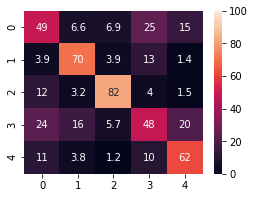


              precision    recall  f1-score   support

         Pop       0.49      0.48      0.48      1889
       Metal       0.70      0.77      0.74      1791
     Hip-Hop       0.82      0.78      0.80      1816
        Rock       0.48      0.42      0.45      2137
     Country       0.62      0.70      0.66      1654

    accuracy                           0.62      9287
   macro avg       0.62      0.63      0.63      9287
weighted avg       0.62      0.62      0.62      9287



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


def print_stat(y, pred):

    conf_m = confusion_matrix(y, pred)
    print('Confusion matrix:\n', conf_m, '\n')

    fractions = (conf_m / conf_m.sum(axis=0) * 100.0).round(2)

    plt.figure(figsize=(8/10*conf_m.shape[0], 6/10*conf_m.shape[0]))
    sns.heatmap(fractions, annot=True, vmin=0, vmax=100)
    plt.show()


def modelling(Model, title, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RND_STATE)

    print('Training the ' + title)

    nm_model = Model().fit(X_train, y_train)
    print('Done')

    y_pred = nm_model.predict(X_test)
    print_stat(y_test, y_pred)
    print()
    print(classification_report(y_test, y_pred, target_names=g_cols_pl.keys()))


# fit the the Naive Bayes classifier to the training set,
# using the bag of words as features and the genre labels
# as the target variable
target_genres = np.array([g_cols_pl[g] for g in genres])
modelling(MultinomialNB, 'Naive Bayes classifier', X, target_genres)

> The Naive Bayes classifier achieve rather good accuracy. *Metal* and *Hip-Hop* are easier for the classifier whereas *Pop* and *Rock* are harder, in line with the tSNE results.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

> Answer:

Training the Naive Bayes classifier, Word Vectors
Done
Confusion matrix:
 [[ 673  114  184  911    9]
 [  44 1150   85  497    1]
 [ 133   39 1362  261    0]
 [ 330  233  181 1386   10]
 [ 326   87  116 1062   93]] 



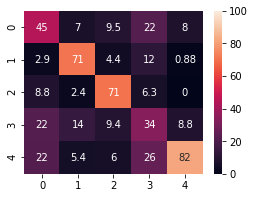


              precision    recall  f1-score   support

         Pop       0.45      0.36      0.40      1891
       Metal       0.71      0.65      0.68      1777
     Hip-Hop       0.71      0.76      0.73      1795
        Rock       0.34      0.65      0.44      2140
     Country       0.82      0.06      0.10      1684

    accuracy                           0.50      9287
   macro avg       0.60      0.49      0.47      9287
weighted avg       0.59      0.50      0.47      9287



In [ ]:
from sklearn.preprocessing import MinMaxScaler


def compute_wvs(genres, songs, vocab_set, weights):

    song_vecs, song_genres = [], []

    for genre, song in zip(genres, songs):

        wv, w_cnt = 0, 0
        for word in song:
            if word in vocab_set:
                wv = wv + model.wv[word] * weights.get(word, 1)
                w_cnt += 1

        if w_cnt > 0:
            song_vecs.append(wv / w_cnt)
            song_genres.append(genre)

    return song_vecs, song_genres


song_vecs, song_genres = compute_wvs(genres, songs, vocab_set, {})
genre_ids = np.array([g_cols_pl[g] for g in song_genres])
modelling(MultinomialNB, 'Naive Bayes classifier, Word Vectors',
    MinMaxScaler().fit_transform(np.array(song_vecs)),
    genre_ids)

Using of the word vectors as features drives *Country* precision high and recall low, apparently because the model misclassifies many pop and rock songs as countries.

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


> Answer:

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('count', CountVectorizer(
        strip_accents='unicode',
        stop_words=stop_words,
        min_df=1e-4)),
    ('tfidf', TfidfTransformer())]
).fit([' '.join(song) for song in songs])
tfidf_index = dict(zip(
    pipe['count'].get_feature_names(),
    pipe['tfidf'].idf_))

Training the Naive Bayes classifier, Word Vectors, TfIdf
Done
Confusion matrix:
 [[ 241   86  164 1396    4]
 [  15 1056   78  627    1]
 [  52   30 1333  380    0]
 [  75  173  151 1734    7]
 [  56   60   90 1427   51]] 



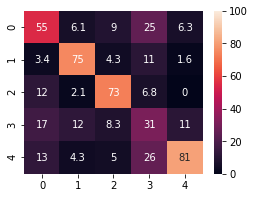


              precision    recall  f1-score   support

         Pop       0.55      0.13      0.21      1891
       Metal       0.75      0.59      0.66      1777
     Hip-Hop       0.73      0.74      0.74      1795
        Rock       0.31      0.81      0.45      2140
     Country       0.81      0.03      0.06      1684

    accuracy                           0.48      9287
   macro avg       0.63      0.46      0.42      9287
weighted avg       0.62      0.48      0.43      9287



In [ ]:
song_vecs, song_genres = compute_wvs(genres, songs,
    vocab_set & set(pipe['count'].get_feature_names()), tfidf_index)
modelling(MultinomialNB, 'Naive Bayes classifier, Word Vectors, TfIdf',
    MinMaxScaler().fit_transform(song_vecs),
    [g_cols_pl[g] for g in song_genres])

> Adding TfIdf weighting didn't help much, *Pop* and *Country* recall became even lower. Seemingly the word vectors are harder to classify for the Naive Bayes than the tokens.

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them, so you keep a maximum of 128 words (after cleaning stop words and rare words).
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
- Freezing the weights trained using Word2vec (preventing it from updating)
- Random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

> To employ the CNN architecture to the lyrics' genre classification we take advantage of the computed tCNE embeddings $-$ we have top $15000$ `word, genre` tuples each with `background, x, y` data. The algorithm is as follows:

> - Normalize to $[0, 255]$ and quantize tSNE 2D-coordinates
- For each song we start with zero $5\times256\times256$ matrix `M`, where number of channels is equal to number of genres
- For each song's unique word that is present in the top-$3000$ we put its `background` to `M[genre, x, y]` forming an "image" of the song
- Downscale the image to $5\times64\times64$ by $4\times4$ means to fit dataset in Colab's memory
- Train the CNN with architecture similar for politicians' image recognition using the known genres as targets

> For implementation we reuse the NN training code from HW4/HW1 Q8.

In [ ]:
import time
import copy


def train_model(model, dataloaders, dataset_sizes, define_params, phases=('train', 'val'), rnd_labels=False):

    # move model to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion, optimizer, scheduler, num_epochs = define_params(model)
    if phases == ('val',):
        num_epochs = 1

    since = time.time()

    # init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # learning statistics
    stats = {
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}}

    # full class index
    classes_idx = np.arange(len(class_names))

    for epoch in range(num_epochs):

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in phases:

            if phase == 'train':

                # set model to training mode
                model.train()  
            else:
                # set model to evaluate mode; in evaluate mode, we don't perform
                # backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:

                if rnd_labels and phase == 'train':
                    # insert random labels

                    batch_idx = np.arange(len(labels))
                    n_rnd = len(labels) // 10
                    rnd_class = np.random.choice(classes_idx, n_rnd)
                    rnd_sample = np.random.choice(batch_idx, n_rnd)
                    labels[rnd_sample] = torch.tensor(rnd_class, dtype=labels.dtype)

                # prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == 'train'):

                    # apply the model to the inputs; after applying softmax the output
                    # is the probability of each class, but here we don't need it as we find max output
                    # whereas softmax is monotonic and doesn't interfere with maxing
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # ==== backward pass + optimizer step ====
                        # in train mode we track the gradients to allow back-propagation

                        # perform a step in the opposite direction of the gradient
                        loss.backward() 

                        # adapt the optimizer
                        optimizer.step()

                # collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':

                # adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # collect learning statistics
            stats[phase]['loss'].append(epoch_loss)
            stats[phase]['acc'].append(epoch_acc.item())

            # keep the results of best model so far
            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc

                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model.to(torch.device('cpu')), stats

> We transform top's data from pandas to dictionary to get $\times100$ access speed gain.

In [ ]:
upscale = 256 - 1
downscale = 64

tsne_d = {}

lw_tsne = (lw[['word', 'background']]
    .join((lw[['Yx', 'Yy']] * upscale).round(0).astype(int))
    .join(lw['genre'].apply(lambda g: g_cols_pl[g])))

def lw_lookup(row):
    word = row['word']
    if word not in tsne_d.keys():
        tsne_d[word] = {}
        tsne_d[word]['Y'] = tuple(row[['Yx', 'Yy']].to_list())
        tsne_d[word]['tsne'] = []
    tsne_d[word]['tsne'].append(tuple(row[['genre', 'background']].to_list()))

lw_tsne.apply(lw_lookup, axis='columns')
lw_tsne.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 451 to 43065
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   word        15000 non-null  object 
 1   background  15000 non-null  float64
 2   Yx          15000 non-null  int64  
 3   Yy          15000 non-null  int64  
 4   genre       15000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.3+ MB


In [ ]:
from skimage.transform import downscale_local_mean
import torch


rand_idx = np.arange(len(songs))
np.random.shuffle(rand_idx)

tsne_emb = np.empty(
    (len(g_cols_pl), upscale + 1, upscale + 1),
    dtype=np.float32)

tsne_n = 46429
i_split = int(tsne_n * 0.8)

tsne_set = [
    [torch.empty((i_split, len(g_cols_pl), downscale, downscale), dtype=torch.float32),
     []],
    [torch.empty((tsne_n - i_split, len(g_cols_pl), downscale, downscale), dtype=torch.float32),
     []]]

# song counter
song_cnt = -1
split = 0

print('Computing tSNE song embeddings...')

for i in rand_idx:

    w_cnt = 0
    tsne_emb[...] = 0

    for word in set(songs[i]):

        if word not in tsne_d.keys():
            continue

        if w_cnt == 0:
            # first word in song

            # increase song counter
            song_cnt += 1

        w_cnt += 1

        ix = tsne_d[word]
    
        for genre, back in ix['tsne']:
            tsne_emb[genre, ix['Y'][0], ix['Y'][1]] = back

    if w_cnt == 0:
        continue

    if song_cnt >= i_split:
        song_cnt = 0
        split = 1

    tsne_set[split][0][song_cnt] = torch.tensor(downscale_local_mean(tsne_emb, (1, 4, 4)))
    tsne_set[split][1].append(g_cols_pl[genres[i]])

    if (song_cnt + 1) % 1000 == 0:
        print(f'{"Test" if split else "Train"} song {song_cnt + 1} of {tsne_n - i_split if split else i_split}')

print(f'Total {tsne_n} embeddings')

Computing tSNE song embeddings...
Train song 1000 of 37143
Train song 2000 of 37143
Train song 3000 of 37143
Train song 4000 of 37143
Train song 5000 of 37143
Train song 6000 of 37143
Train song 7000 of 37143
Train song 8000 of 37143
Train song 9000 of 37143
Train song 10000 of 37143
Train song 11000 of 37143
Train song 12000 of 37143
Train song 13000 of 37143
Train song 14000 of 37143
Train song 15000 of 37143
Train song 16000 of 37143
Train song 17000 of 37143
Train song 18000 of 37143
Train song 19000 of 37143
Train song 20000 of 37143
Train song 21000 of 37143
Train song 22000 of 37143
Train song 23000 of 37143
Train song 24000 of 37143
Train song 25000 of 37143
Train song 26000 of 37143
Train song 27000 of 37143
Train song 28000 of 37143
Train song 29000 of 37143
Train song 30000 of 37143
Train song 31000 of 37143
Train song 32000 of 37143
Train song 33000 of 37143
Train song 34000 of 37143
Train song 35000 of 37143
Train song 36000 of 37143
Train song 37000 of 37143
Test song 100

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD, lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Normalize(0.0, 1.0)]),
    'val': transforms.Compose([
        transforms.Normalize(0.0, 1.0)])}

In [ ]:
def tsne_set_dataloaders(data_transforms):

    datasets = {}
    datasets['train'] = TensorDataset(
        tsne_set[0][0],
        torch.tensor(tsne_set[0][1]))
    datasets['val'] = TensorDataset(
        tsne_set[1][0],
        torch.tensor(tsne_set[1][1]))

    dataloaders = {
        'train': DataLoader(
            datasets['train'], batch_size=20, shuffle=True, num_workers=2),
        'val': DataLoader(
            datasets['val'], batch_size=20, shuffle=True, num_workers=2)}

    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
    print('dataset_sizes: ', dataset_sizes)

    class_names = list(g_cols_pl.keys())
    print('class_names:', class_names)

    return dataloaders, dataset_sizes, class_names

In [ ]:
tsne_dataloaders, tsne_dataset_sizes, class_names = tsne_set_dataloaders(data_transforms)

dataset_sizes:  {'train': 37143, 'val': 9286}
class_names: ['Pop', 'Metal', 'Hip-Hop', 'Rock', 'Country']


> We employ $4$ convolutional layers each with ReLU activations and maxpooling, followed by a dropout and $2$ dense layers.

In [ ]:
class Net(nn.Module):

    def __init__(self, k_size=3, fc1_fc2=512):

        k_2 = k_size // 2

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(5, 32, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.dropout = nn.Dropout(0.8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(256 * 4 * 4, fc1_fc2)
        self.fc2 = nn.Linear(fc1_fc2, 5)


    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
tsne_model = Net()
print(tsne_model)

Net(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.8, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
channels, H, W = 5, 64, 64
summary(tsne_model, input_size=(channels, H, W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,472
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
         MaxPool2d-8            [-1, 256, 4, 4]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                  [-1, 512]       2,097,664
           Linear-11                    [-1, 5]           2,565
Total params: 2,489,221
Trainable params: 2,489,221
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forw

In [ ]:
def tsne_define_params(model):

    # for a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # # use Stochastic Gradient Descent as the optimizer,
    # # with a learning rate of 0.001 and momentum
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters())

    # decay LR by a factor of 0.3 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

    num_epochs = 25

    return criterion, optimizer, scheduler, num_epochs

In [ ]:
tsne_model, stats = train_model(
    tsne_model, tsne_dataloaders, tsne_dataset_sizes, tsne_define_params, rnd_labels=False)

Epoch 1/25
----------
train Loss: 1.1729 Acc: 0.4932
val Loss: 1.0387 Acc: 0.5718

Epoch 2/25
----------
train Loss: 1.0468 Acc: 0.5662
val Loss: 0.9943 Acc: 0.5952

Epoch 3/25
----------
train Loss: 1.0203 Acc: 0.5759
val Loss: 0.9800 Acc: 0.5939

Epoch 4/25
----------
train Loss: 1.0054 Acc: 0.5864
val Loss: 0.9609 Acc: 0.6046

Epoch 5/25
----------
train Loss: 0.9879 Acc: 0.5960
val Loss: 0.9665 Acc: 0.6105

Epoch 6/25
----------
train Loss: 0.9776 Acc: 0.6003
val Loss: 0.9497 Acc: 0.6080

Epoch 7/25
----------
train Loss: 0.9681 Acc: 0.6050
val Loss: 0.9549 Acc: 0.6136

Epoch 8/25
----------
train Loss: 0.9509 Acc: 0.6117
val Loss: 0.9325 Acc: 0.6246

Epoch 9/25
----------
train Loss: 0.9408 Acc: 0.6167
val Loss: 0.9346 Acc: 0.6218

Epoch 10/25
----------
train Loss: 0.9358 Acc: 0.6167
val Loss: 0.9326 Acc: 0.6232

Epoch 11/25
----------
train Loss: 0.9297 Acc: 0.6240
val Loss: 0.9422 Acc: 0.6198

Epoch 12/25
----------
train Loss: 0.9226 Acc: 0.6250
val Loss: 0.9255 Acc: 0.6289

E

> Quick experimentation demonstrated that the idea is viable as we achieved the validation accuracy on par with the Naive Bayes classifier. Further optimization such as increasing tSNE matrix image resolution and employing a more elaborate NN architecture will definitely improve the classification results.

In [ ]:
del tsne_model

In [ ]:
del tsne_dataloaders['train'], tsne_dataloaders['val']
del tsne_set[0][0], tsne_set[1][0]

-------------------------------------------------

> Also we implemented the CNN architecture suggested in [prakashpandey9](https://github.com/prakashpandey9/Text-Classification-Pytorch) repo. Their idea is as follows:
- Compute word vectors for the lyrics' vocabulary of size $300$
- For each song use no more than first $200$ words (we use $128$) and create $1\times H=200(128)\times W=300$ matrix from the song's consecutive words
- The CNN employ $3$ convolutional layers with kernels of $300$ width and different heights, with RelU activations and $N$ output channels; their stripe and padding conserves height.
- Layers computed in parallel and then maxpooled together for full height, leaving just $N$ features
- The features are then classified by $2$ dense layers

> We experimented with different hyperparameters such as kernel heights, optimization algorithms, learning rates, but have never got more than $0.24$ accuracy.

In [ ]:
import torch

wv_dataset = torch.zeros((len(genre_ids), 1, 128, 300), dtype=torch.float32)

rand_idx = np.arange(len(genre_ids))
np.random.shuffle(rand_idx)

# song counter
song_cnt = -1

for song in songs:

    w_cnt = 0
    for word in song:

        if word not in vocab_set:
            continue

        if w_cnt == 0:
            # first word in song, increase song counter
            song_cnt += 1

        wv_dataset[rand_idx[song_cnt], 0, w_cnt] = torch.tensor(model.wv[word])
        
        w_cnt += 1
        if w_cnt == 128:
            break

In [ ]:
def set_dataloaders(data_transforms):

    split_id = int(wv_dataset.shape[0] / 5 * 4)

    wv_datasets = {}
    wv_datasets['train'] = TensorDataset(
        wv_dataset[:split_id],
        torch.tensor(genre_ids[rand_idx[:split_id]]))
    wv_datasets['val'] = TensorDataset(
        wv_dataset[split_id:],
        torch.tensor(genre_ids[rand_idx[split_id:]]))

    dataloaders = {
        'train': DataLoader(
            wv_datasets['train'], batch_size=500, shuffle=True, num_workers=2),
        'val': DataLoader(
            wv_datasets['val'], batch_size=500, shuffle=True, num_workers=2)}

    dataset_sizes = {x: len(wv_datasets[x]) for x in ['train', 'val']}
    print('dataset_sizes: ', dataset_sizes)

    class_names = list(g_cols_pl.keys())
    print('class_names:', class_names)

    return dataloaders, dataset_sizes, class_names

In [ ]:
dataloaders, dataset_sizes, class_names = set_dataloaders(data_transforms)

dataset_sizes:  {'train': 37144, 'val': 9287}
class_names: ['Pop', 'Metal', 'Hip-Hop', 'Rock', 'Country']


In [ ]:
class CNN(nn.Module):

    def __init__(self, out_ch=64, fc1_fc2=100):

        # k_2 = k_size // 2

        super(CNN, self).__init__()
        self.out_ch = out_ch
        self.conv1 = nn.Conv2d(1, out_ch, kernel_size=(5, 300), stride=(1, 1), padding=(2, 0))
        self.conv2 = nn.Conv2d(1, out_ch, kernel_size=(11, 300), stride=(1, 1), padding=(5, 0))
        self.conv3 = nn.Conv2d(1, out_ch, kernel_size=(17, 300), stride=(1, 1), padding=(8, 0))
        self.pool = nn.MaxPool2d(kernel_size=(128, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
        self.dropout = nn.Dropout(0.8)
        self.bn = nn.BatchNorm2d(out_ch)
        self.fc1 = nn.Linear(3 * out_ch, fc1_fc2)
        self.fc2 = nn.Linear(fc1_fc2, 5)


    def forward(self, x):

        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x)))
        x3 = self.pool(F.relu(self.conv3(x)))
        x = torch.cat((x1, x2, x3))
        x = self.bn(x).view(-1, self.out_ch * 3)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
cnn_model = CNN(out_ch=384, fc1_fc2=128)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 384, kernel_size=(5, 300), stride=(1, 1), padding=(2, 0))
  (conv2): Conv2d(1, 384, kernel_size=(11, 300), stride=(1, 1), padding=(5, 0))
  (conv3): Conv2d(1, 384, kernel_size=(17, 300), stride=(1, 1), padding=(8, 0))
  (pool): MaxPool2d(kernel_size=(128, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.8, inplace=False)
  (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [ ]:
channels, H, W = 1, 128, 300
summary(cnn_model, input_size=(channels, H, W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 128, 1]         576,384
         MaxPool2d-2            [-1, 384, 1, 1]               0
            Conv2d-3          [-1, 384, 128, 1]       1,267,584
         MaxPool2d-4            [-1, 384, 1, 1]               0
            Conv2d-5          [-1, 384, 128, 1]       1,958,784
         MaxPool2d-6            [-1, 384, 1, 1]               0
       BatchNorm2d-7            [-1, 384, 1, 1]             768
           Dropout-8                 [-1, 1152]               0
            Linear-9                  [-1, 128]         147,584
           Linear-10                    [-1, 5]             645
Total params: 3,951,749
Trainable params: 3,951,749
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 1.15
Params size (MB): 15.07
Estima

In [ ]:
def define_params(model):

    # for a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # # use Stochastic Gradient Descent as the optimizer,
    # # with a learning rate of 0.001 and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.025)

    # decay LR by a factor of 0.3 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    num_epochs = 10

    return criterion, optimizer, scheduler, num_epochs

In [ ]:
cnn_model, stats = train_model(cnn_model, dataloaders, dataset_sizes, define_params, rnd_labels=True)

Epoch 1/10
----------
train Loss: 1.6436 Acc: 0.2107
val Loss: 1.6076 Acc: 0.2180

Epoch 2/10
----------
train Loss: 1.6175 Acc: 0.2121
val Loss: 1.6074 Acc: 0.2204

Epoch 3/10
----------
train Loss: 1.6121 Acc: 0.2206
val Loss: 1.6063 Acc: 0.2336

Epoch 4/10
----------
train Loss: 1.6100 Acc: 0.2253
val Loss: 1.6068 Acc: 0.2348

Epoch 5/10
----------
train Loss: 1.6096 Acc: 0.2261
val Loss: 1.6078 Acc: 0.2308

Epoch 6/10
----------
train Loss: 1.6099 Acc: 0.2248
val Loss: 1.6074 Acc: 0.2352

Epoch 7/10
----------
train Loss: 1.6094 Acc: 0.2253
val Loss: 1.6067 Acc: 0.2362

Epoch 8/10
----------
train Loss: 1.6112 Acc: 0.2233
val Loss: 1.6064 Acc: 0.2341

Epoch 9/10
----------
train Loss: 1.6094 Acc: 0.2252
val Loss: 1.6066 Acc: 0.2361

Epoch 10/10
----------
train Loss: 1.6088 Acc: 0.2271
val Loss: 1.6069 Acc: 0.2235

Training complete in 7m 7s
Best val Acc: 0.236244


In [ ]:
del cnn_model

In [ ]:
del dataloaders['train'], dataloaders['val']
del wv_dataset